In [1]:
import os
import os.path as osp
import argparse
from cv2 import imread, normalize, resize
import cv2
import json
import numpy as np
import time
import datetime
import random
import logging
import sys
from PIL import Image

from utils import euclidean_metric, one_hot, count_acc
from utils import pprint, set_gpu, ensure_path, AverageMeter, Timer, accuracy, one_hot

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch import nn, optim, autograd
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision
from random import sample, random

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset, TensorDataset, WeightedRandomSampler
import os.path as osp
from tqdm import tqdm

from random import sample, random

batch_size = 32
num_epoch = 100

/home/iai/anaconda3/envs/sh_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Customdataset(data.Dataset):
    def __init__(self,transform = None):
        dalist=None
        self.file_paths = []
        self.label = []
        self.transform = transform
        
        
        file_path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/imageset/single_image.2class.subject-split.trainval-repeat0/fold.5-5/ratio/100%/train.1-1.txt' # 폴더 경로

        with open(file_path) as f:
            lines = f.readlines()

        image_names = [line.rstrip('\n') for line in lines]
        
                
        with open('/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/annotation/single_image.6class.json', 'r') as json_file:
            data = json.load(json_file)
            
        path_image = "/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/image/"
        files = os.listdir(path_image)
        
        for file in files:
            if file in image_names:
                self.label.append(data['single_image'][file]['class'][0])
                self.file_paths.append(path_image + '/' + file)

    def __len__(self):

        return len(self.file_paths)


    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.label[idx]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, int(label)

In [3]:
data_transforms = transforms.Compose([
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),

        ])

In [4]:
##커스텀 데이터셋
dataset = Customdataset(transform=data_transforms)
train_size = int(0.8 * len(dataset))
print(f"train size :{train_size}")
val_size = len(dataset) - train_size
print(f"test_size :{val_size}")
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"train_dataset :{len(train_dataset)}")
print(f'test dataset :{len(val_dataset)}')


train size :208
test_size :52
train_dataset :208
test dataset :52


In [5]:
from torchsampler import ImbalancedDatasetSampler

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size, #배치사이즈
                                               shuffle = True
                                               )

val_loader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,                                              
                                               shuffle = True
                                              )

In [6]:
from torchvision import models
import torch

resnet50_pretrained = models.resnet50(pretrained=True)

num_classes = 6
num_ftrs = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda:0')
resnet50_pretrained.to(device)
print()

In [7]:
from pytorchtools import EarlyStopping # 위 링크의 깃허브 파일에서 임포트

early_stopping = EarlyStopping(patience = 4, verbose = True, min_epoch=30)

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet50_pretrained.parameters(), lr=0.00005)

train_loss_arr =[]
val_loss_arr =[]
n = len(train_loader)

for i in range(num_epoch):
    
    train_running_loss = 0.0
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y =  label.to(device)
        
        optimizer.zero_grad()
        
        output = resnet50_pretrained.forward(x)
        
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    
    train_loss_arr.append(train_running_loss / n)
        
    resnet50_pretrained.eval()
    val_running_loss = 0.0
    for j,[image,label] in enumerate(val_loader):
        
        x = image.to(device)
        y =  label.to(device)
        
        y_pred = resnet50_pretrained(x)
        loss = loss_func(y_pred, y)

        val_running_loss += loss.item()
    
    val_loss_arr.append(val_running_loss / len(val_loader))       
    early_stopping(val_running_loss, resnet50_pretrained)
    
    print('[%d] train_loss: %.3f , val_loss: %.3f ' %(i + 1, train_running_loss / len(train_loader) , val_running_loss / len(val_loader)))
        
    if early_stopping.early_stop and i > 20: # 조건 만족 시 조기 종료
        break


Validation loss decreased (inf --> 2.980363).  Saving model ...
[1] train_loss: 1.711 , val_loss: 1.490 
Validation loss decreased (2.980363 --> 2.376329).  Saving model ...
[2] train_loss: 1.418 , val_loss: 1.188 
Validation loss decreased (2.376329 --> 1.915030).  Saving model ...
[3] train_loss: 1.329 , val_loss: 0.958 
Not enough epoch
[4] train_loss: 1.329 , val_loss: 1.168 
Not enough epoch
[5] train_loss: 1.288 , val_loss: 1.061 
Validation loss decreased (1.915030 --> 1.528928).  Saving model ...
[6] train_loss: 1.212 , val_loss: 0.764 
Validation loss decreased (1.528928 --> 1.481778).  Saving model ...
[7] train_loss: 1.002 , val_loss: 0.741 
Not enough epoch
[8] train_loss: 1.055 , val_loss: 0.804 
Not enough epoch
[9] train_loss: 1.028 , val_loss: 0.793 
Not enough epoch
[10] train_loss: 0.862 , val_loss: 0.799 
Validation loss decreased (1.481778 --> 0.890192).  Saving model ...
[11] train_loss: 0.671 , val_loss: 0.445 
Validation loss decreased (0.890192 --> 0.555663).  S

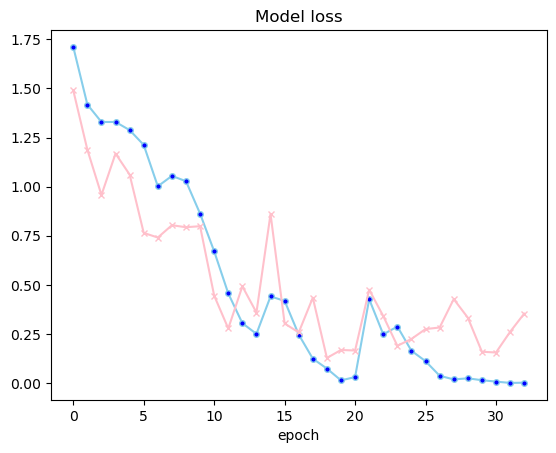

In [8]:
import matplotlib.pyplot as plt


plt.plot(train_loss_arr,
         color='skyblue',
         marker='o', markerfacecolor='blue',
         markersize=4)

plt.plot(val_loss_arr,
         color='pink',
         marker='x', markerfacecolor='red',
         markersize=4)

plt.title('Model loss')
plt.xlabel('epoch')
plt.show()

In [9]:
class Customdataset(torch.utils.data.Dataset):
    def __init__(self,transform = None):
        dalist=None
        self.file_paths = []
        self.label = []
        self.transform = transform

        file_path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/imageset/single_image.2class.subject-split.trainval-repeat0/fold.5-5/ratio/100%/test.1.txt' # 폴더 경로

        with open(file_path) as f:
            lines = f.readlines()

        image_names = [line.rstrip('\n') for line in lines]


        path = '/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/image' # 폴더 경로
        files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
        
        with open('/home/iai/Desktop/SH/cognex/d-sub-15pin_for-seoultech/annotation/single_image.6class.json', 'r') as json_file:
            data = json.load(json_file)  
    
        for file in files:
            if file in image_names and file.split('_')[1] == 'repeat':
                self.label.append(data['single_image'][file]['class'][0])
                self.file_paths.append(path + '/' + file)

    def __len__(self):

        return len(self.file_paths)


    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.label[idx]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, int(label)
    
    
test_dataset = Customdataset(transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = 16                                       
                                              )

In [10]:
correct = 0
total = 0
pred_ls = []
real_ls = []

context_ls = [] 

with torch.no_grad(): # 파라미터 업데이트 같은거 안하기 때문에 no_grad를 사용.
  # net.eval() # batch normalization이나 dropout을 사용하지 않았기 때문에 사용하지 않음. 항상 주의해야함.
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = resnet50_pretrained(images)
    _, predicted = torch.max(outputs.data, 1) # 6개의 class중 가장 값이 높은 것을 예측 label로 추출.
    total += labels.size(0) # test 개수
    correct += (predicted == labels).sum().item() # 예측값과 실제값이 맞으면 1 아니면 0으로 합산.
    
    pred_ls.append(predicted.cpu().numpy())
    real_ls.append(labels.cpu().numpy())


print(f'accuracy of 1600 test images: {100*correct/total}%')

accuracy of 1600 test images: 86.5%


In [11]:
pred = np.array(pred_ls).reshape(-1)
real = np.array(real_ls).reshape(-1)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(pred, real))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       281
           1       0.67      0.69      0.68        29
           2       0.83      1.00      0.91        25
           3       0.83      0.83      0.83        30
           4       0.17      1.00      0.29         5
           5       1.00      1.00      1.00        30

    accuracy                           0.86       400
   macro avg       0.74      0.90      0.77       400
weighted avg       0.92      0.86      0.88       400



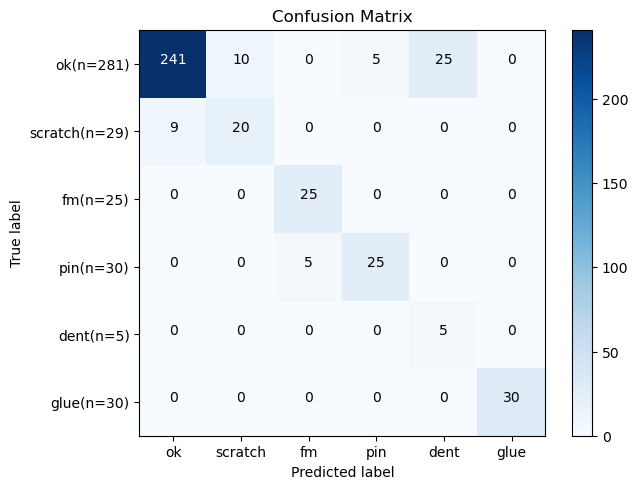

In [13]:
import itertools

def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_df = confusion_matrix(pred, real)    
label=['ok', 'scratch', 'fm', 'pin', 'dent', 'glue']
plot_confusion_matrix(cm_df, labels=label, normalize=False)